<h1> Lab Six: Convolutional Network Architectures </h1>

<h4> Adam Ashcraft, Maya Muralidhar, Nora Potenti, Michael Watts </h4>

<h1> 1.0 Preparation </h1>

<h2> 1.1 Business Understanding </h2>

This is a dataset of approximately 4,300 images of flowers. These images have been taken from Flickr, Google, and Yandax and are divided into five categories: dasies, dandelions, roses, sunflowers, and tulips. The images were collected by performing a data scrape of these image hosting services by the dataset creator Alexander Mamaev. The images are in standard definition quality and do not have a standardized size. According to the Kaggle page, the data was collected to answer the question, “What kind of flower is that?” The creator also includes a prediction task for the data on Kaggle, “You can use this dataset to recognize plants from the photo.” 

This tool would primary serve the completely flower illiterate. It provides a very basic stepping stone into the wide world of botany for those with no experience in the field. With an application like this, a user will be able to successfully differentiate between different types of flowers based on subtler nuances than simply factors like color. Ideally, this would prevent someone from buying sunflowers instead of tulips simply because they are the same color. 


Another plant photo identification tool already exists in the market, Plantsnap. According to the Plantsnap website, it boasts a 96% success rate. In order for our tool to be considered viable, it must have at least, if not greater than, a 96% success rate.  

<hr>
Kaggle dataset: https://www.kaggle.com/alxmamaev/flowers-recognition <br>
Plantsnap self reported success rate: https://plantsnap.com/faq/

<h2> 1.2 Evaluation Criteria </h2>

Before we determine our evaluation criteria, let’s take a moment to look at our data.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
import glob
import pickle
from PIL import Image
from matplotlib.pyplot import imshow
from IPython.display import display
from sklearn.model_selection import train_test_split
import cv2
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from scipy.misc import imresize
from sklearn import metrics as mt
from keras.models import load_model

C:\Users\Nora\Anaconda3.6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#use glob to get all file names in each folder
daisyFiles = glob.glob("flowers/daisy/*")
dandelionFiles = glob.glob("flowers/dandelion/*")
roseFiles = glob.glob("flowers/rose/*")
sunflowerFiles = glob.glob("flowers/sunflower/*")
tulipFiles = glob.glob("flowers/tulip/*")

daisies = []
dandelions = []
roses = []
sunflowers = []
tulips = []
#function to take image name, open image as numpy array and add to list
def addImageToArray(imageFileArray, imageArray):
    for file in imageFileArray:
        imageArray.append(np.asarray(Image.open(file)))
        
addImageToArray(daisyFiles,daisies)
addImageToArray(dandelionFiles,dandelions)
addImageToArray(roseFiles,roses)
addImageToArray(sunflowerFiles,sunflowers)
addImageToArray(tulipFiles,tulips)

In [3]:
def convertToGrayScale(RGBArray):
    return np.dot(RGBArray[...,:3], [0.3, 0.59, 0.11])
def convertAllImagesToGrey(ImageArray):
    for i in range (0, len(ImageArray)):
        ImageArray[i] = convertToGrayScale(ImageArray[i])
convertAllImagesToGrey(daisies)
convertAllImagesToGrey(dandelions)
convertAllImagesToGrey(roses)
convertAllImagesToGrey(sunflowers)
convertAllImagesToGrey(tulips)

([<matplotlib.patches.Wedge at 0x28602974630>,
 [Text(0.939244,0.572556,'Daisy'),
  Text(-0.316623,1.05345,'Dandelion'),
  Text(-1.09793,-0.0674027,'Rose'),
  Text(-0.429837,-1.01254,'Sunflower'),
  Text(0.828258,-0.723871,'Tulip')],
 [Text(0.512315,0.312303,'17.4%'),
  Text(-0.172703,0.574607,'24.4%'),
  Text(-0.598873,-0.0367651,'18.2%'),
  Text(-0.234457,-0.552295,'17.1%'),
  Text(0.451777,-0.394839,'22.9%')])

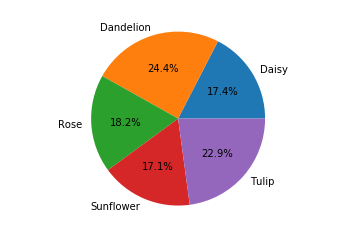

In [4]:
pieValues = [len(daisies), len(dandelions), len(roses), len(sunflowers), len(tulips)]
plt.axis("equal")
plt.pie(x=pieValues,labels=['Daisy', 'Dandelion', 'Rose', 'Sunflower','Tulip'], autopct='%1.1f%%')

A false negative and a false positive both represent the same idea here, an erroneous categorization of the flower for our user. Considering the fact, we are working with total flower novices, we will want to minimize both our false positive and false negatives rates as much as possible. We cannot assume our user is knowledgeable enough to detect them himself. We must also take into account the slight class imbalance we see in the above graphic. Dandelions and Tulips represent almost 50% of the classes in the data set. In order to focus on minimizing both the false positives and false negatives as well consider the class imbalance, we will use F1 score.


In [8]:
%%capture --no-display

croppedDaisies = [imresize(x,size=(330,500), interp='nearest') for x in daisies]    

croppedDandelions = [imresize(x,size=(330,500), interp='nearest') for x in dandelions]   

croppedRoses =[imresize(x,size=(330,500), interp='nearest') for x in roses]  

croppedSunflowers = [imresize(x,size=(330,500), interp='nearest') for x in sunflowers]    

croppedTulips = [imresize(x,size=(330,500), interp='nearest') for x in tulips] 

In [9]:
def flattenMatrix(arrayOfMatracies):
    flattenedArray = []
    for m in arrayOfMatracies:
        flattenedArray.append(m.flatten())
        
    return flattenedArray


<h2> 1.2 Data Division </h2>

For our data division, we will do a stratified shuffle train test split across our data then use a stratified shuffle split. The stratification will correct for the class imbalance of the data. The data is currently grouped into 5 groups, 1 per class. This is not an accurate reflection of how our model will be used. It is highly unlikely that the application will only ever see one kind of flower at a time, iteration after iteration. It will more than likely be exposed to a wide variety of flower with every use. In order to better model this, the data will be shuffled in order to split the groups of classes up and distribute them among the k-folds. The train-test split will give us a section of data never before seen by our model we can use to easily check its performance against. 



In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=1)
X = np.array(croppedDaisies + croppedTulips + croppedDandelions + croppedRoses + croppedSunflowers)
y = np.array(len(croppedDaisies)*[0] + len(croppedTulips)*[1] + len(croppedDandelions)*[2] + len(croppedRoses)*[3] + len(croppedSunflowers)*[4])
X_split, X_test, y_split, y_test = train_test_split(X, y, stratify = y, shuffle = True, random_state=42, test_size=0.2)

X_test_resize = [imresize(x,size=(33,50), interp='nearest') for x in X_test]

X_test_resize = np.stack(X_test_resize,axis=0)
X_test_resize = flattenMatrix(X_test_resize)


y_test_ohe = keras.utils.to_categorical(y_test, 5)

C:\Users\Nora\Anaconda3.6\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


<h1> 2.0 Convolutional Neural Nets </h1>

<h2> 2.1 Data Expansion </h2>

We will want to assume that our photographer has no idea what features he is trying to capture in the image. This means he does not know good angles, lighting, or focus for his flower photograph. In order to mirror an amateur as much as possible with our data, we will create a wide variety of augmentations with our data generator.   


In [11]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False, #adding to each pixel
    samplewise_std_normalization=False, #adding to each picture
    zca_whitening=False,
    rotation_range=180, # used, Int. Degree range for random rotations.
    width_shift_range=0.5, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.5, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None)

<h2> 2.2 Simple CNN </h2>

In [12]:

NUM_CLASSES = 5 

print(len(X_test_resize[0]))

1650


Fold # 1 :


/hpc/applications/anaconda/3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 Score is  0.0538698053619


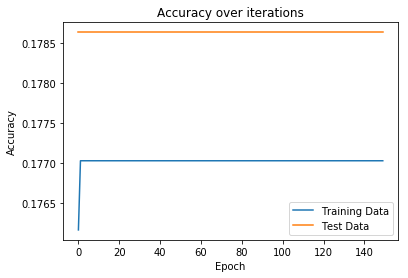

Fold # 2 :
F1 Score is  0.0535468564111


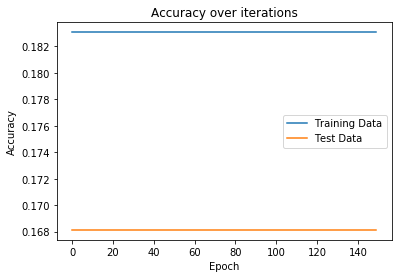

Fold # 3 :
F1 Score is  0.0538698053619


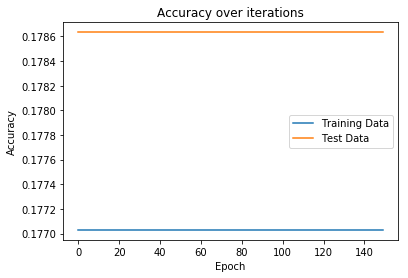

Fold # 4 :
F1 Score is  0.0538698053619


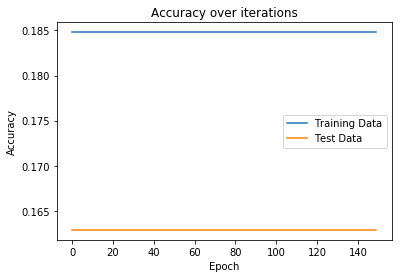

Fold # 5 :
F1 Score is  0.0535468564111


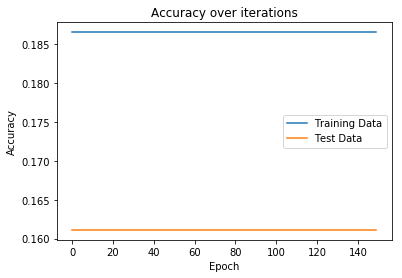

Fold # 6 :
F1 Score is  0.0535468564111


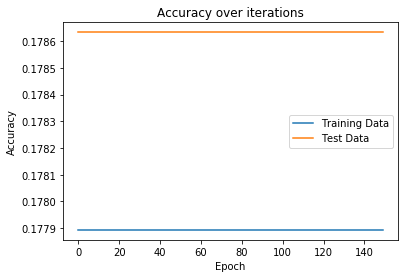

Fold # 7 :
F1 Score is  0.0535468564111


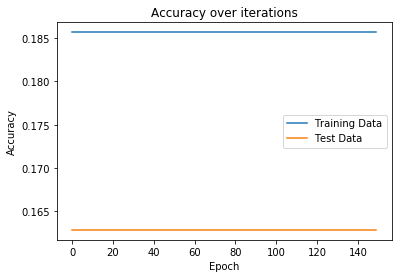

Fold # 8 :
F1 Score is  0.0535468564111


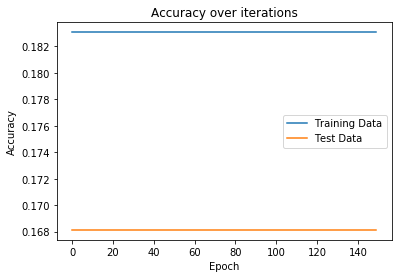

Fold # 9 :
F1 Score is  0.0535468564111


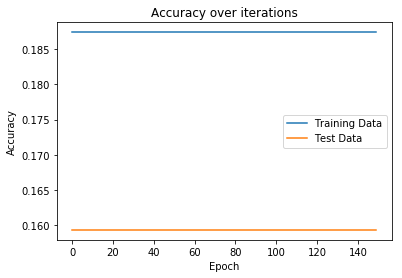

Fold # 10 :
F1 Score is  0.0535468564111


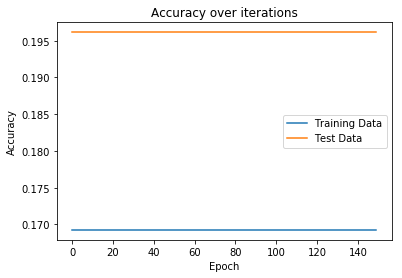

In [122]:
# import warnings
# warnings.filterwarnings('ignore')
mlp = Sequential()
mlp.add( Dense(input_dim=len(X_test_resize[0]), units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])
count = 0
for train_index, test_index in sss.split(X_split, y_split): #SSS k folds, will run and print F1 score for each
    count = count + 1
    print('Fold #', count, ':')
    X_train, X_test = X_split[train_index], X_split[test_index]
    y_train, y_test = y_split[train_index], y_split[test_index]
    
    NUM_CLASSES = 5 
    X_train_resize = [imresize(x,size=(33,50), interp='nearest') for x in X_train]
    X_train_resize = np.stack(X_train_resize,axis=0)
    X_train_resize = flattenMatrix(X_train_resize)

    X_test_resize = [imresize(x,size=(33,50), interp='nearest') for x in X_test]
    X_test_resize = np.stack(X_test_resize,axis=0)
    X_test_resize = flattenMatrix(X_test_resize)
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)


    info = mlp.fit(np.array(X_train_resize), y_train_ohe, 
        batch_size=32, epochs=150, validation_split=0.33,
        shuffle=True, verbose=0)
    y_hat = mlp.predict(np.array(X_test_resize))
    y_hat_ohe = keras.utils.to_categorical(y_hat.argmax(axis=1), 5)

    score = mt.f1_score(y_test_ohe, y_hat_ohe, average='weighted')
    print('F1 Score is ', score)
    plt.plot(info.history['acc'])
    plt.plot(info.history['val_acc'])
    plt.title('Accuracy over iterations')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Data', 'Test Data'])
    plt.show()


In [123]:
mlp.save('large_data/mlp.h5')

In [13]:
mlp = load_model('large_data/mlp.h5')

Fold # 1 :


/hpc/applications/anaconda/3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 Score is  0.0538698053619


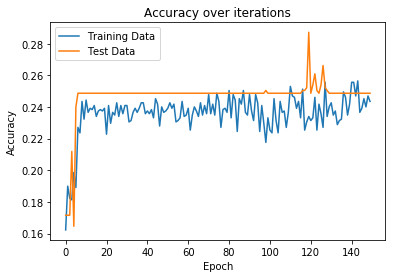

Fold # 2 :
F1 Score is  0.0535468564111


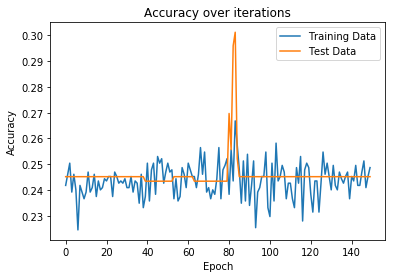

Fold # 3 :
F1 Score is  0.0538698053619


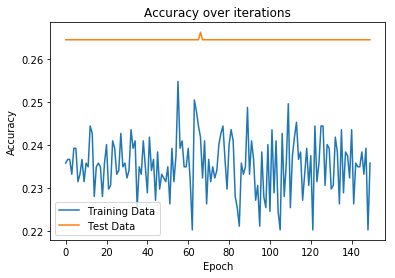

Fold # 4 :
F1 Score is  0.0538698053619


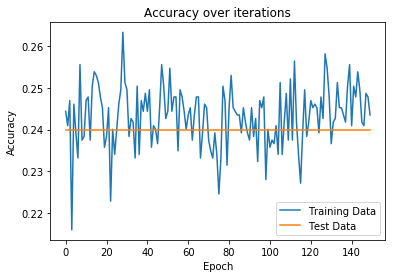

Fold # 5 :
F1 Score is  0.0535468564111


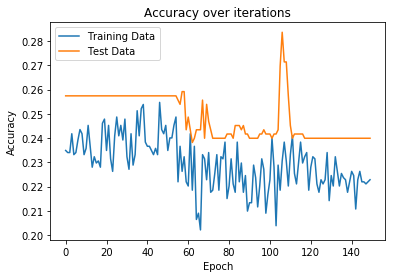

Fold # 6 :
F1 Score is  0.0535468564111


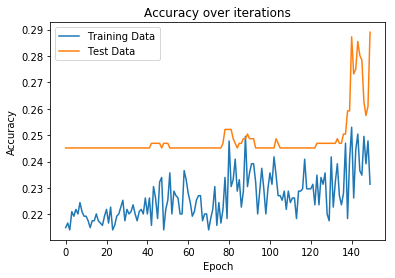

Fold # 7 :
F1 Score is  0.0535468564111


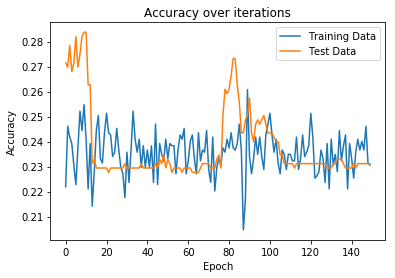

Fold # 8 :
F1 Score is  0.0535468564111


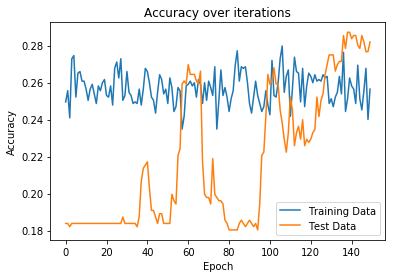

Fold # 9 :
F1 Score is  0.0535468564111


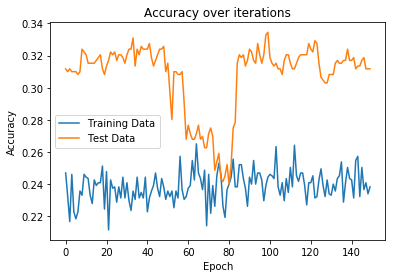

Fold # 10 :
F1 Score is  0.0535468564111


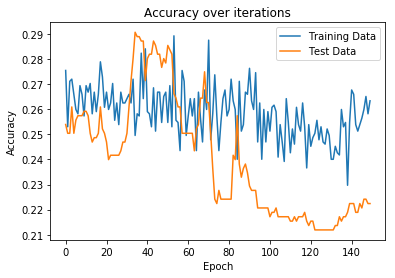

In [124]:
cnn = Sequential()
cnn.add(Reshape((1,33,50), input_shape=(1,1650)))
cnn.add(Conv2D(filters=16, kernel_size= (10, 10), padding='same', input_shape=(3,33,50)))
cnn.add(Conv2D(filters=24, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(3, 5), data_format="channels_first"))
# add one layer on flattened output
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(100, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])
count = 0
for train_index, test_index in sss.split(X_split, y_split): #SSS k folds, will run and print F1 score for each
    count = count + 1
    print('Fold #', count, ':')
    X_train, X_test = X_split[train_index], X_split[test_index]
    y_train, y_test = y_split[train_index], y_split[test_index]
    
    NUM_CLASSES = 5 

    X_train_resize = [imresize(x,size=(33,50), interp='nearest') for x in X_train]

#     X_train_resize = np.stack(X_train_resize,axis=0)

    X_train_resize = flattenMatrix(X_train_resize)

    X_test_resize = [imresize(x,size=(33,50), interp='nearest') for x in X_test]
 
    
#     X_test_resize = np.stack(X_test_resize,axis=0)
    X_test_resize = flattenMatrix(X_test_resize)

    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

   # we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras 
    info = cnn.fit(np.expand_dims(X_train_resize, axis=1), y_train_ohe, 
        batch_size=32, validation_split=0.33, epochs=150, 
        shuffle=True, verbose=0)
    yhat = np.argmax(cnn.predict(np.expand_dims(X_test_resize, axis=1)), axis=1)
    y_hat_ohe = keras.utils.to_categorical(y_hat.argmax(axis=1), 5)

    score = mt.f1_score(y_test_ohe, y_hat_ohe, average='weighted')
    print('F1 Score is ', score)

    plt.plot(info.history['acc'])
    plt.plot(info.history['val_acc'])
    plt.title('Accuracy over iterations')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Data', 'Test Data'])
    plt.show()


In [125]:
cnn.save('large_data/cnn.h5')

In [14]:
cnn = load_model('large_data/cnn.h5')

In [16]:
from mlxtend.evaluate import mcnemar_table, mcnemar
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        f_cnn = mt.f1_score(y_test,yhat_cnn, average= 'weighted')
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(f_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        f_mlp = mt.f1_score(y_test,yhat_mlp, average= 'weighted')
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(f_mlp))
        
    contingency = mcnemar_table(y_target=y_test, 
                               y_model1=yhat_cnn,
                               y_model2=yhat_mlp)
    return contingency

C:\Users\Nora\Anaconda3.6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Nora\Anaconda3.6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[113  97]
 [140 511]]


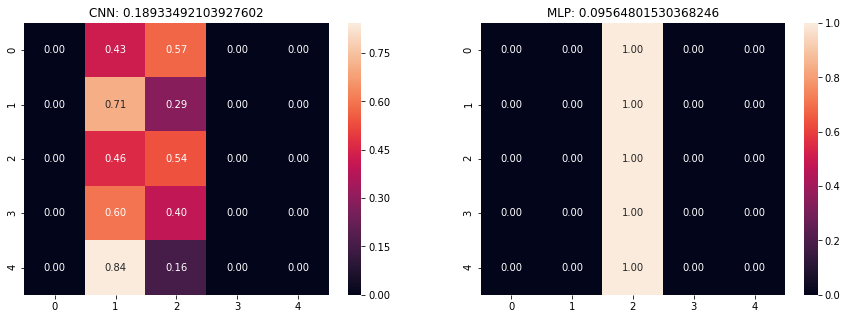

In [17]:
contingency1 = compare_mlp_cnn(cnn,mlp, np.array(X_test_resize),y_test)

print(contingency1)

In [18]:
np_contingency1 = np.array(contingency1)
chiSq, p = mcnemar(ary=np_contingency1, corrected=True)
print("Chi Squared: ", chiSq)
print("P-val: ", p)

Chi Squared:  7.443037974683544
P-val:  0.006368230364894328


In this comparison, the sample size is big enough that we can use a significance level of 0.05 to compare our p-value to. Our null hypothesis is that one of the models is not significantly bigger than the other, but because our p-value is smaller than our significance level, we can reject our null hypothesis. This means that there is a significant difference between the two models.

In [19]:
daisies_color = [cv2.imread(img, 1) for img in daisyFiles]
dandelions_color = [cv2.imread(img, 1) for img in dandelionFiles]
roses_color = [cv2.imread(img, 1) for img in roseFiles]
sunflowers_color = [cv2.imread(img, 1) for img in sunflowerFiles]
tulips_color = [cv2.imread(img, 1) for img in tulipFiles]

In [20]:
def matrix_resize_color(arrayToAlter):
    croppedImages = []
    for i in range(0, len(arrayToAlter)):
        if(arrayToAlter[i].shape[0] >= 244 and arrayToAlter[i].shape[1] >= 327):
            #crop image
            image = arrayToAlter[i][0:244, 0:327]
            #final resize to ensure all matricies are the same size and remove any extra data from converting
            croppedImages.append(cv2.resize(image, (500, 330), interpolation = cv2.INTER_AREA))
    return croppedImages
cropped_daisies_color = matrix_resize_color(daisies_color)
cropped_dandelions_color = matrix_resize_color(dandelions_color)
cropped_roses_color = matrix_resize_color(roses_color)
cropped_sunflowers_color = matrix_resize_color(sunflowers_color)
cropped_tulips_color = matrix_resize_color(tulips_color)
X_color = np.array(cropped_daisies_color + cropped_tulips_color + cropped_dandelions_color + cropped_roses_color + cropped_sunflowers_color)
y_color = np.array(len(cropped_daisies_color)*[0] + len(cropped_tulips_color)*[1] + len(cropped_dandelions_color)*[2] + len(cropped_roses_color)*[3] + len(cropped_sunflowers_color)*[4])
y_color.shape

(1295,)

In [21]:
def flatten_matrix_color(array_of_matrices):
    total_array = []
    flattened_array = []
    for i in range(0, 3):
        for m in array_of_matrices:
            flattened_array.append(m[:,:,i].flatten())
        total_array.append(np.array(flattened_array))
        flattened_array = []
    return np.array(total_array).reshape(len(array_of_matrices), 3, int(array_of_matrices[0].size/3))

# y is still y
X_train_color, X_test_color, y_train_color, y_test_color = train_test_split(X_color, y_color, test_size=0.2)
NUM_CLASSES = 5 
X_train_resize_color = [imresize(x,size=(33,50, 3), interp='nearest') for x in X_train_color]
X_train_resize_color = np.stack(X_train_resize_color,axis=0)
#X_train_resize_color = flatten_matrix_color(X_train_resize_color)
X_test_resize_color = [imresize(x,size=(33,50, 3), interp='nearest') for x in X_test_color]
X_test_resize_color = np.stack(X_test_resize_color,axis=0)
#X_test_resize_color = flatten_matrix_color(X_test_resize_color)
y_train_ohe_color = keras.utils.to_categorical(y_train_color, NUM_CLASSES)
y_test_ohe_color = keras.utils.to_categorical(y_test_color, NUM_CLASSES)

C:\Users\Nora\Anaconda3.6\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
C:\Users\Nora\Anaconda3.6\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [22]:
X_train_resize_color.shape

(1036, 33, 50, 3)

In [23]:
from keras.applications.inception_v3 import InceptionV3

inception_model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 7s 0us/step


In [24]:
from keras.models import Input, Model

x_inception = inception_model.output
x_inception = Dense(1024, activation='relu',kernel_initializer='he_uniform')(x_inception)

predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x_inception)

model_inception = Model(inputs=inception_model.input, outputs=predictions)

for layer in inception_model.layers:
    layer.trainable = False
    
model_inception.compile(optimizer='adamax', loss='categorical_crossentropy',metrics=['accuracy'])

model_inception.fit(X_train_resize_color,y_train_ohe_color,epochs=1,batch_size=64,verbose=1)

Epoch 1/1
1036/1036 [==============================] - 6s 6ms/step - loss: nan - acc: 0.1660


In [25]:
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
summarize_net(model, X_test_resize_color, y_test, title_text='Transfer Learning, ResNet:')

NameError: name 'model' is not defined

<h2> 2.3 Resnet </h2>

In [113]:

from keras.regularizers import l2
# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.models import Input, Model
img_w = 33
img_h = 50
l2_lambda = 0.000001
input_holder = Input(shape=(1, img_w, img_h ))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (1, img_w,img_h),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_first")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_first")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_first")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_first")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_first")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_first")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_first")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(5)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)



In [114]:
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=[ 'accuracy'])

Fold # 1 :


/hpc/applications/anaconda/3/lib/python3.6/site-packages/keras/preprocessing/image.py:895: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1729, 1, 33, 50) (50 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')
/hpc/applications/anaconda/3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/hpc/applications/anaconda/3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F1 Score is  0.12425359224


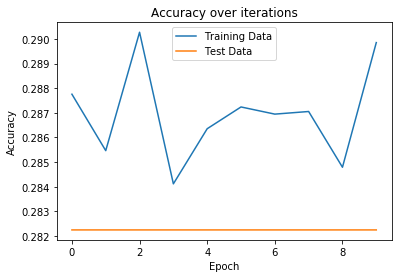

Fold # 2 :
F1 Score is  0.129737326025


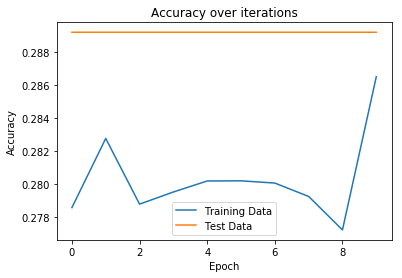

Fold # 3 :
F1 Score is  0.117971523662


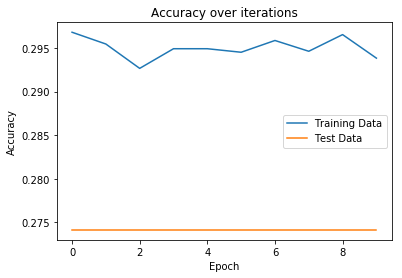

Fold # 4 :
F1 Score is  0.119307089818


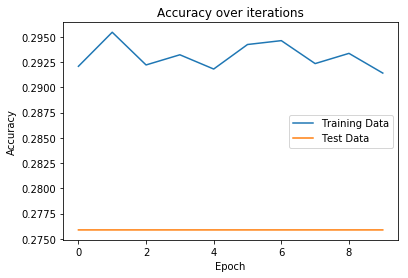

Fold # 5 :
F1 Score is  0.125161240884


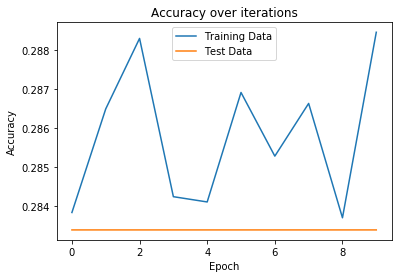

Fold # 6 :
F1 Score is  0.127899350797


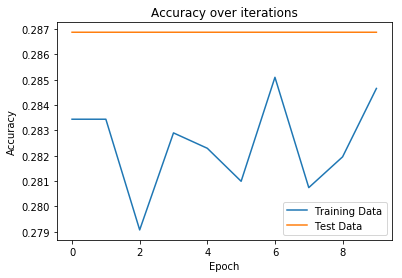

Fold # 7 :
F1 Score is  0.12927689338


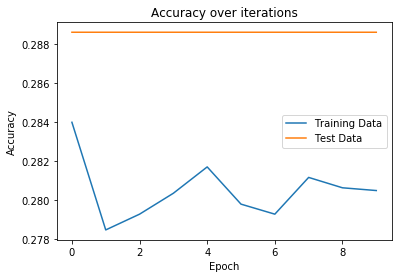

Fold # 8 :
F1 Score is  0.127441424535


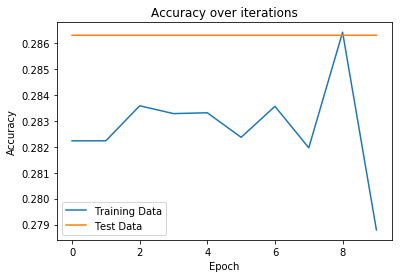

Fold # 9 :
F1 Score is  0.121995592682


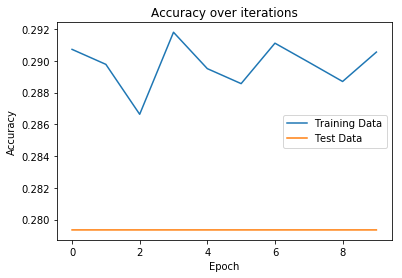

Fold # 10 :
F1 Score is  0.117971523662


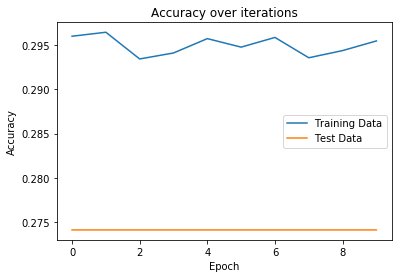

In [117]:
count = 0
for train_index, test_index in sss.split(X_split, y_split): #SSS k folds, will run and print F1 score for each
    count = count + 1
    print('Fold #', count, ':')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#     print(X_train[0].shape)
    X_train = [imresize(x,size=(33,50), interp='nearest') for x in X_train]
    X_test = [imresize(x,size=(33,50), interp='nearest') for x in X_test]
#     X_train = np.stack(X_train,axis=0)
#    X_train = flattenMatrix(X_train)
#     X_test = np.stack(X_test,axis=0)
#    X_test = flattenMatrix(X_test)
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    X_test = (np.expand_dims(X_test, axis=1))
    X_train = (np.expand_dims(X_train, axis=1))

    y_train_ohe = keras.utils.to_categorical(y_train, 5)
    y_test_ohe = keras.utils.to_categorical(y_test, 5)
    info = resnet.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=500), 
                      steps_per_epoch=int(len(X_train)/100), # how many generators to go through per epoch
                      epochs=10, verbose=0,
                      validation_data=(X_test,y_test_ohe)
                     )
    y_hat = resnet.predict(X_test)

#    print(keras.backend.argmax(y_hat, axis=-1))
    y_hat_ohe = keras.utils.to_categorical(y_hat.argmax(axis=1), 5)
#     print(y_hat[0])
#     print(y_hat[0].shape)
#     print(y_hat_ohe[0])
#     print(y_hat_ohe[0].shape)
#     print(y_test_ohe[0])
#     print(y_test_ohe[0].shape)
    score = mt.f1_score(y_test_ohe, y_hat_ohe, average='weighted')
    print('F1 Score is ', score)
    plt.plot(info.history['acc'])
    plt.plot(info.history['val_acc'])
    plt.title('Accuracy over iterations')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Data', 'Test Data'])
    plt.show()



In [127]:
resnet.save('large_data/resnet_cnn.h5')

In [26]:
resnet = load_model('large_data/resnet_cnn.h5')

In [27]:
def compare_mlp_cnn2(cnn, mlp, X_test, X_test_resnet, y_test): #new one since input for this is different than other CNN
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test_resnet), axis=1)
        f_cnn = mt.f1_score(y_test,yhat_cnn, average= 'weighted')
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(f_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        f_mlp = mt.f1_score(y_test,yhat_mlp, average= 'weighted')
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(f_mlp))
        
    contingency = mcnemar_table(y_target=y_test,
                            y_model1=yhat_cnn,
                            y_model2=yhat_mlp)
    return contingency

C:\Users\Nora\Anaconda3.6\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.
C:\Users\Nora\Anaconda3.6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Nora\Anaconda3.6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


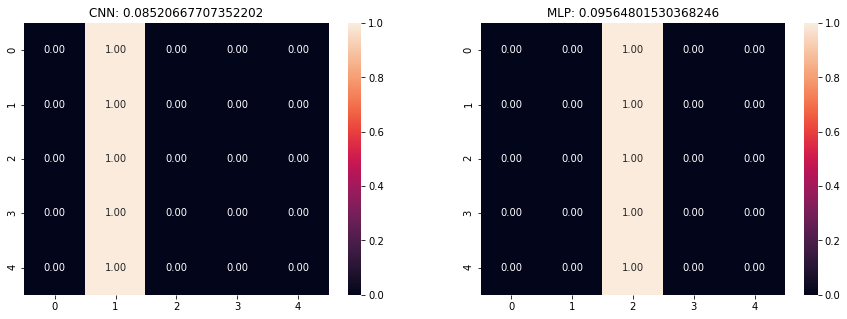

In [28]:
X_test_resize_resnet = [imresize(x,size=(33,50), interp='nearest') for x in X_test]
X_test_resize_resnet = (np.expand_dims(X_test_resize_resnet, axis=1))
contingency2 = compare_mlp_cnn2(resnet,mlp, np.array(X_test_resize), np.array(X_test_resize_resnet),y_test)

In [29]:
np_contingency2 = np.array(contingency2)
chiSq, p = mcnemar(ary=np_contingency2, corrected=True)
print("Chi Squared: ", chiSq)
print("P-val: ", p)

Chi Squared:  0.3538083538083538
P-val:  0.5519651900440818


Again we use a significance level of 0.05, and our p-value of 0.55 is larger than this level, meaning we cannot reject our null hypothesis for these two models. We cannot conclude that one of the models is significantly more accurate than the other.